In [2]:
import pandas as pd
import sqlite3
import zipfile

# 1.1 Movies Database

Take the movies dataset and turn it into a single `sqlite` database. It should have one table for each csv file in the movies dataset

In [3]:
# My 'movies database' is in a zip file

zf = zipfile.ZipFile('/Users/mayarossi/DS-Workshop/m2-3-exploration/data/archive.zip')
all_dfs = [pd.read_csv(zf.open(files)) for files in zf.namelist()]

In [4]:

conn = sqlite3.connect('data/movies.db')

for i in range(0,len(all_dfs)):
    all_dfs[i].to_sql(
        name=zf.namelist()[i].replace('.csv',''), #to use each csv name as the file name
        con=conn, 
        schema=None, 
        if_exists='replace', 
        index=True, 
    )

In [5]:
pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=conn)

,name
0,credits
1,keywords
2,links
3,links_small
4,movies_metadata
5,ratings
6,ratings_small


# 1.2 Queries

**1.2.1** Use a single query to pull the original title of movies with a budget above $5m

**1.2.2** Use a query to pull the english-language films with the word `war` in their title

**1.2.3** Left join the average ratings from the `ratings` table onto the `movies_metadata` table, so you can have a relation between budget and rating. Hint: use a subquery.

In [59]:
# 1.2.1 Use a single query to pull the original title of movies with a budget above $5m

pd.read_sql(
    """
SELECT original_title 
FROM movies_metadata 
WHERE budget > 5000000
""", con=conn)

,original_title
0,Jumanji
1,Heat
2,Sabrina
3,GoldenEye
4,The American President
...,...
2182,The Emoji Movie
2183,Pattaya
2184,House of the Long Shadows
2185,Все и сразу


In [13]:
# 1.2.2 Use a query to pull the english-language films with the word war in their title

pd.read_sql(
    """
SELECT original_title 
FROM movies_metadata
WHERE original_language = 'en' 
    AND original_title LIKE '% war %' --war in the middle
    OR original_title LIKE 'war %' --war at the start
    OR original_title LIKE '% war' --war at the end
LIMIT 5 --just shows the first 5
    """,
con=conn)

,original_title
0,The War
1,The War Room
2,War Stories Our Mother Never Told Us
3,In Love and War
4,The War at Home


In [18]:
# 1.2.3 Left join the average ratings from the ratings table onto the movies_metadata table, so you can have a relation between budget and rating. Hint: use a subquery.

pd.read_sql(
"""
SELECT id, original_title, budget, avg_rating, n_users--, vote_count
FROM movies_metadata
LEFT JOIN(
    SELECT
        AVG(rating) as avg_rating,
        movieId,
        --COUNT(*) as vote_count,
        COUNT(DISTINCT(userId)) as n_users
    FROM ratings r
    GROUP BY movieId
    )
ON movieId = id
WHERE avg_rating != 0
LIMIT 5
""", con=conn)

,id,original_title,budget,avg_rating,n_users
0,862,Toy Story,30000000,3.598930,374
1,8844,Jumanji,65000000,3.760163,123
2,949,Heat,60000000,3.905544,2345
3,710,GoldenEye,58000000,2.740334,1319
4,1408,Cutthroat Island,98000000,3.710181,13888


# 2. Baseball Database

The [Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) has an sqlite version. Download it for these exercises.

**2.1** Which player has had the most homeruns?

**2.2** Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query



In [19]:
conn_b = sqlite3.connect('data/lahmansbaseballdb.sqlite')
# pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", con=conn_b) --to see all tables

In [79]:
# pd.read_sql("PRAGMA table_info(people)", con=conn_b) --to see all column names

In [20]:
# 2.1 Which player has had the most homeruns?

pd.read_sql(
    """
SELECT nameFirst, nameLast, p.playerID, SUM(HR) as sum_HR
FROM people p
LEFT JOIN batting b
    ON b.playerID = p.playerID
GROUP BY p.playerID
ORDER BY sum_HR DESC
LIMIT 1
    """,
con=conn_b)

,nameFirst,nameLast,playerID,sum_HR
0,Barry,Bonds,bondsba01,762


In [23]:
# 2.2 Is there a relation between how many homeruns a player has made in a year and his salary that year? Pull both colums together in a single query

dfbas = pd.read_sql(
    """
SELECT nameFirst, nameLast, s.playerID, salary, s.yearID, HR 
FROM salaries s
INNER JOIN batting
    ON batting.playerID = s.playerID
    AND batting.yearID = s.yearID
INNER JOIN people p
    on p.playerID = s.playerID
--WHERE s.playerID='bondsba01' 
ORDER BY salary DESC
--LIMIT 10 """, con=conn_b)

dfbas.head(10)

,nameFirst,nameLast,playerID,salary,yearID,HR
0,Alex,Rodriguez,rodrial01,33000000.0,2009,30
1,Alex,Rodriguez,rodrial01,33000000.0,2010,30
2,Clayton,Kershaw,kershcl01,33000000.0,2016,0
3,Clayton,Kershaw,kershcl01,32571000.0,2015,0
4,Alex,Rodriguez,rodrial01,32000000.0,2011,16
5,Zack,Greinke,greinza01,31799030.0,2016,0
6,Alex,Rodriguez,rodrial01,30000000.0,2012,18
7,David,Price,priceda01,30000000.0,2016,0
8,Alex,Rodriguez,rodrial01,29000000.0,2013,7
9,Alex,Rodriguez,rodrial01,28000000.0,2008,35


In [ ]:
# There does not seem to be a direct relationship between the salary of a player and their number of homeruns that year. The same names keep coming up as players with the highest salary even if they dont make any homeruns that year, indicating that salary is based on more than just homeruns. 
# See below for stats

In [24]:
dfbas.corr()

,salary,yearID,HR
salary,1.00000,0.36007,0.27569
yearID,0.36007,1.00000,0.02625
HR,0.27569,0.02625,1.00000


In [38]:
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import r2_score

X = dfbas['HR']

y = dfbas['salary']

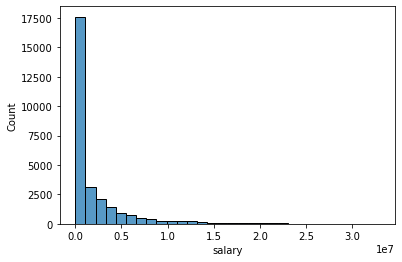

In [135]:
sns.histplot(dfbas.salary, bins=30)

In [57]:
#Using log-linear model (arcsinh because 0's)

import numpy as np
# defining y
# Using arcsinh to get a more 'normal distribution'
dfbas['salary_arcs'] = dfbas.salary.apply(np.arcsinh)
y = dfbas['salary_arcs']

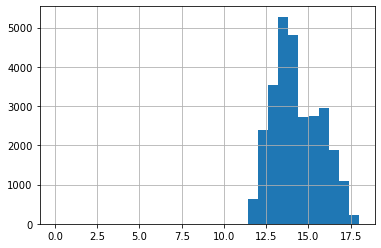

In [46]:
dfbas.salary_arcs.hist(bins=30) #looks better

In [47]:
#Using log-linear model (arcsinh because 0's)

est = sm.OLS(dfbas['salary_arcs'], sm.add_constant(X)).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            salary_arcs   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2325.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        22:48:08   Log-Likelihood:                -48360.
No. Observations:               28294   AIC:                         9.672e+04
Df Residuals:                   28292   BIC:                         9.674e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.0715      0.009   1538.380      0.000      14.054      14.089
HR             0.0457      0.001     48.218      0.000       0.044       0.048
==============================================================================
Omnibus:                      370.361   Durbin-Watson:                   0.140
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              374.291
Skew:                           0.268   Prob(JB):                     5.29e-82
Kurtosis:                       2.823   Cond. No.                         11.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Using Poisson linear regression
est_poisson = sm.Poisson(dfbas['salary'], sm.add_constant(X)).fit()
est_poisson.summary()

Optimization terminated successfully.
         Current function value: 1611070.186287
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                 salary   No. Observations:                28294
Model:                        Poisson   Df Residuals:                    28292
Method:                           MLE   Df Model:                            1
Date:                Sun, 14 Feb 2021   Pseudo R-squ.:                 0.09167
Time:                        22:49:29   Log-Likelihood:            -4.5584e+10
converged:                       True   LL-Null:                   -5.0184e+10
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.3284   5.02e-06   2.86e+06      0.000      14.328      14.328
HR             0.0365    3.4e-07   1.07e+05      0.000       0.037       0.037
==============================================================================
"""

In [ ]:
# As shown by the linear regression, there is a significant linear relationship between HR and salary. However, it is very weak (R2 = 0.076). "The low R-squared graph shows that even noisy, high-variability data can have a significant trend. The trend indicates that the predictor variable still provides information about the response even though data points fall further from the regression line."
# This could mean that Homeruns per year is not the only factor determining salary. Some players have gotten large salaries despite getting no homeruns that year, because they got many homeruns past years. 

In [56]:
y_pred = est_poisson.predict(sm.add_constant(X))
r2_score(dfbas['salary'], y_pred) #slightly lower r2 score than using a log-linear model (r2 = 0.076)

0.07424138082557463